**Predictive modeling including steps:**
1. Prepare Problem
 - Load libraries
 - Load dataset
2. Summarize Data
 - Descriptive statistics
 - Data visualizations
3. Prepare Data
 - Data Cleaning
 - Feature Selection
 - Data Transforms
4. Evaluate Algorithms
 - Split-out validation dataset
 - Test options and evaluation metric
 - Spot-Check Algorithms
 - Compare Algorithms
5. Improve Accuracy
 - Algorithm Tuning
 - Ensembles
6. Finalize Model
 - Predictions on validation dataset
 - Create standalone model on entire training dataset
 - Save model for later use

In [63]:
%matplotlib inline

## Prepare Problem

In [64]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [65]:
# config for show max number of output lines
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [66]:
# Load dataset
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

## Summarize Data

In [67]:
train.head(10)

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0
5,335,4,4,1000,4,0
6,47,2,7,1750,14,1
7,164,1,12,3000,35,0
8,736,5,46,11500,98,1
9,436,0,3,750,4,0


In [68]:
train.shape

(576, 6)

In [69]:
train.describe()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,374.034722,9.439236,5.427083,1356.770833,34.050347,0.239583
std,216.947773,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,0.000000,1.000000,250.000000,2.000000,0.000000
25%,183.750000,2.000000,2.000000,500.000000,16.000000,0.000000
50%,375.500000,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,562.500000,14.000000,7.000000,1750.000000,49.250000,0.000000
max,747.000000,74.000000,50.000000,12500.000000,98.000000,1.000000


In [70]:
train.dtypes

Unnamed: 0                     int64
Months since Last Donation     int64
Number of Donations            int64
Total Volume Donated (c.c.)    int64
Months since First Donation    int64
Made Donation in March 2007    int64
dtype: object

In [71]:
train.columns

Index([u'Unnamed: 0', u'Months since Last Donation', u'Number of Donations',
       u'Total Volume Donated (c.c.)', u'Months since First Donation',
       u'Made Donation in March 2007'],
      dtype='object')

Need to deep dive in to analysis NAN value of each column

Count unique value of each column

In [72]:
for column in train.columns:
    if train[column].isnull().values.any():
        print(column)
        print(train[column].isnull().sum())

### Analysis Made Donation in March 2007, the target of prediction

In [73]:
PREDICT_KEY = 'Made Donation in March 2007'

In [74]:
ID_KEY = 'Unnamed: 0'

In [75]:
print(train['Made Donation in March 2007'].describe())

count    576.000000
mean       0.239583
std        0.427200
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Made Donation in March 2007, dtype: float64


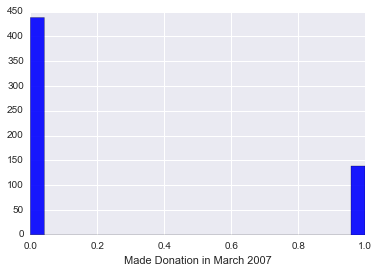

In [76]:
sns.distplot(train['Made Donation in March 2007'], kde = False, color = 'b', hist_kws={'alpha': 0.9})

### Numerical Features

Matrix heatmap, help to identify correlation between the target and other features.

Check more about Correlation_coefficient at https://en.wikipedia.org/wiki/Correlation_coefficient

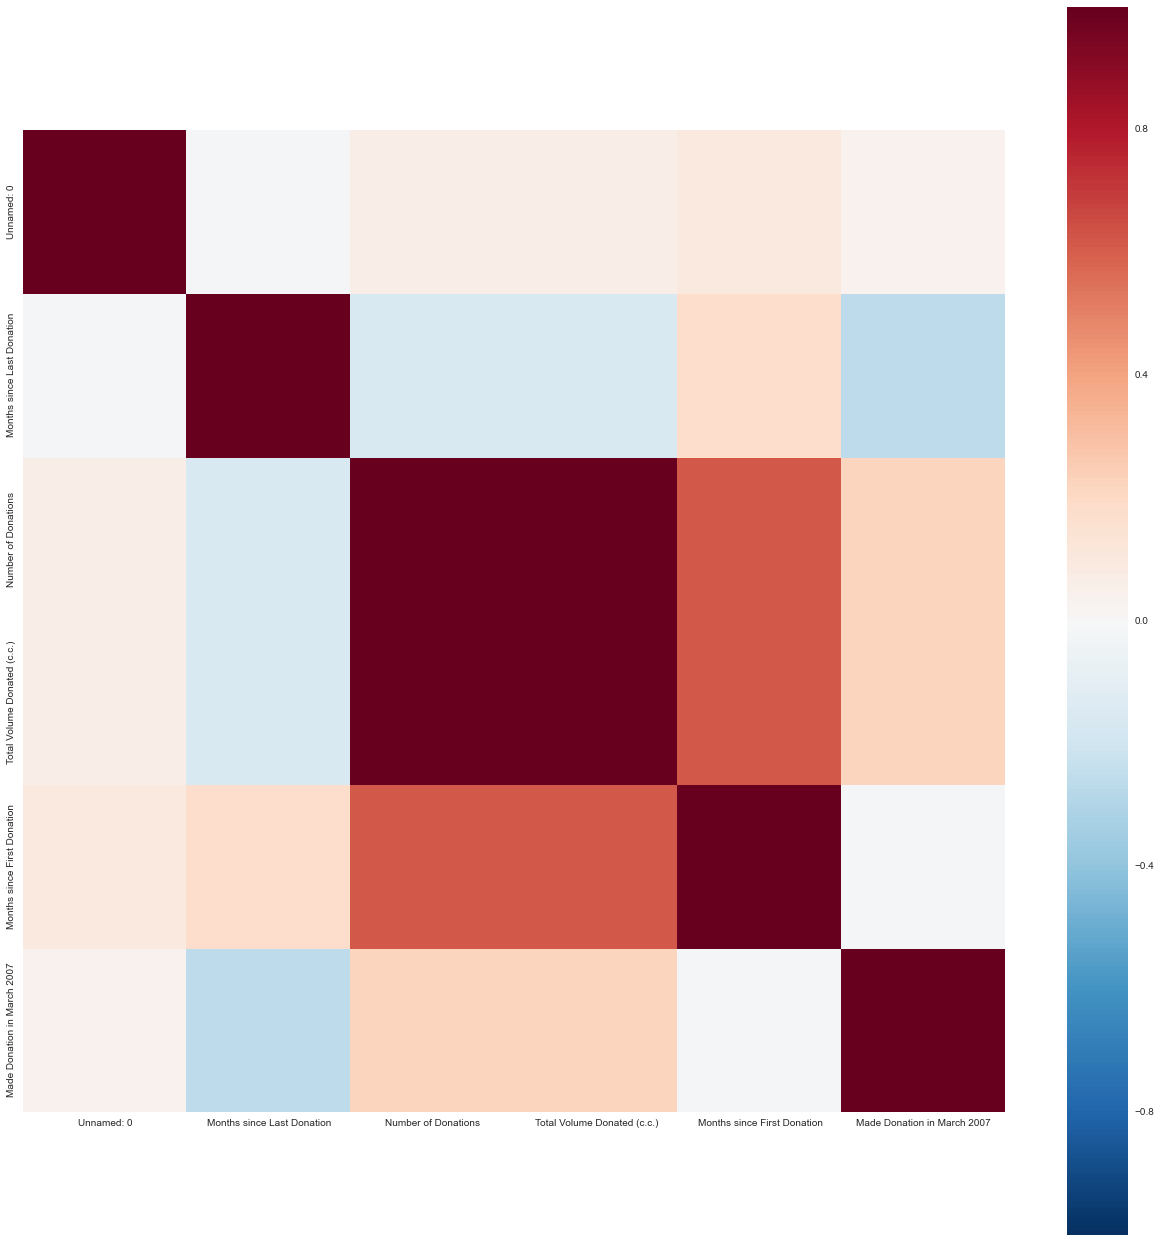

In [77]:
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 0:].corr()
plt.figure(figsize=(22, 22))
sns.heatmap(corr, vmax=1, square=True)

In [78]:
cor_dict = corr[PREDICT_KEY].to_dict()
del cor_dict[PREDICT_KEY]
print("List the numerical features decendingly by their correlation with Made Donation in March 2007:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

List the numerical features decendingly by their correlation with Made Donation in March 2007:

Months since Last Donation: 	-0.261233714362
Number of Donations: 	0.220615343076
Total Volume Donated (c.c.): 	0.220615343076
Unnamed: 0: 	0.041924625511
Months since First Donation: 	-0.0198188895583


"Months since First Donation" doesn't have strong relation with predict value, but should keep here for now.

"Total Volume Donated" has strong relation with "Number of Donated", so need to remove out of feature to avoid overfitting.

Plot data and a linear regression model fit. Help to check if this feature will work fine with linear model or not.
It's seem like this feature has a sightly fit the linear model.

In [79]:
feature_columns = [x for x in train.columns if x != ID_KEY and x != PREDICT_KEY]

In [80]:
feature_columns

['Months since Last Donation',
 'Number of Donations',
 'Total Volume Donated (c.c.)',
 'Months since First Donation']

In [81]:
from __future__ import division
import math

PLOT_REGRESSION_COLUMNS = 2
PLOT_REGRESSION_ROWS = math.ceil(len(feature_columns) / PLOT_REGRESSION_COLUMNS)

In [82]:
PLOT_REGRESSION_ROWS

2.0

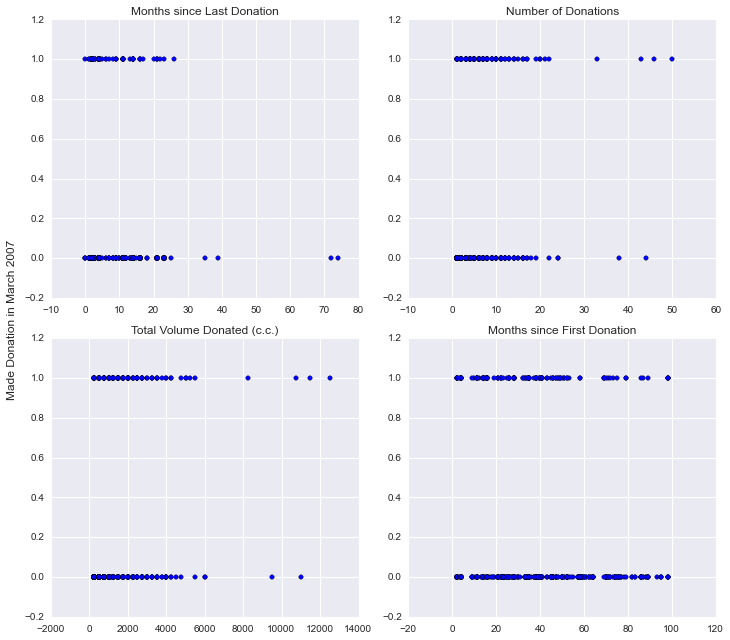

In [83]:
plt.figure(1)
f, axarr = plt.subplots(int(PLOT_REGRESSION_ROWS), PLOT_REGRESSION_COLUMNS, figsize=(10, 9))
predict_values = train[PREDICT_KEY].values

num_rows = 0
num_cols = 0

for column in feature_columns:
    axarr[num_rows, num_cols].scatter(train[column].values, predict_values)
    axarr[num_rows, num_cols].set_title(column)
    
    num_cols += 1
    
    if num_cols >= PLOT_REGRESSION_COLUMNS:
        num_rows += 1
        num_cols = 0

f.text(-0.01, 0.5, PREDICT_KEY, va='center', rotation='vertical', fontsize = 12)
plt.tight_layout()
plt.show()

Scatter chart help to detect linear regression model and detect noise data of each feature. But this is binary classification, so this chart will not help a lot. Just display here as a showcase for other complex data.
There is some outline here, need to consider to remove out.

Let's see historical charts of all numberic features.

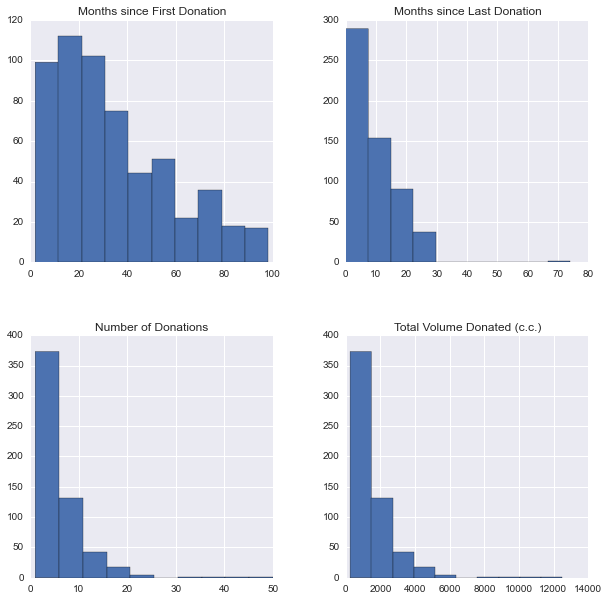

In [84]:
plt.rcParams['figure.figsize'] = (10, 10)
_ = train[feature_columns].hist()

Try some other Visual with seaborn

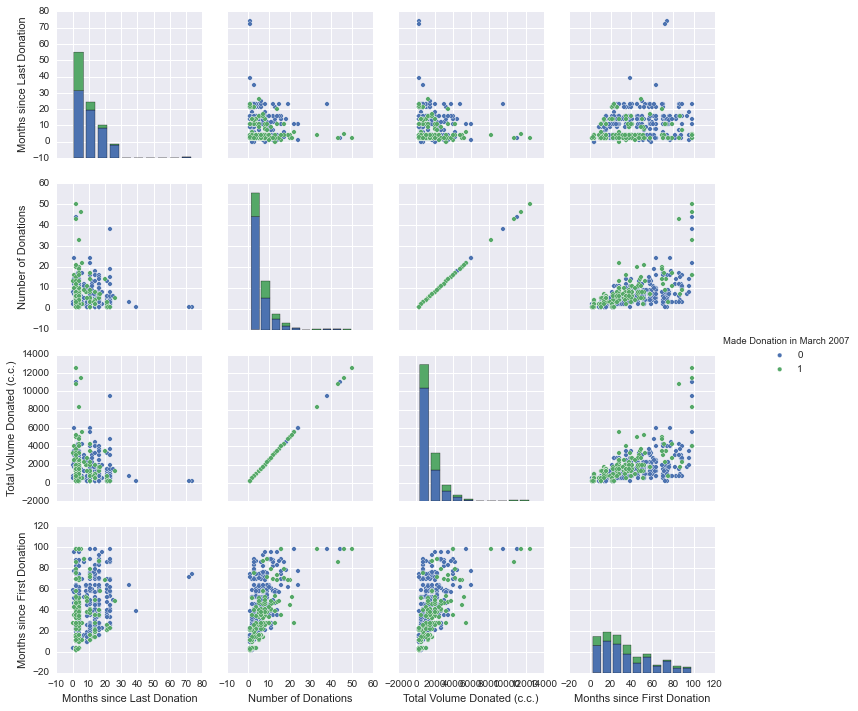

In [85]:
sns.pairplot(train, vars=feature_columns,hue=PREDICT_KEY)

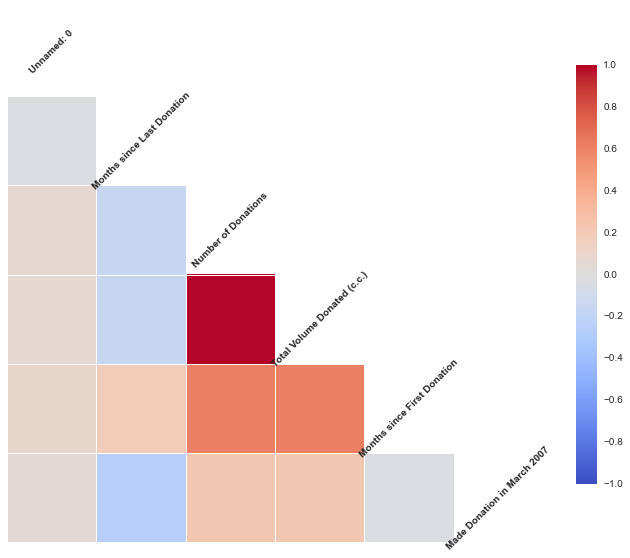

In [86]:
plt.figure(figsize=(12, 10))
_ = sns.corrplot(train, annot=False)

Let's try log method to all features

In [87]:
train_logs = np.log1p(train[feature_columns])

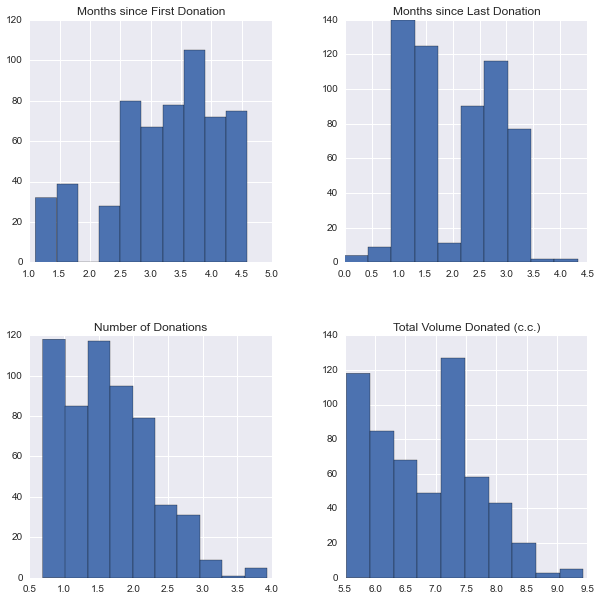

In [88]:
plt.rcParams['figure.figsize'] = (10, 10)
_ = train_logs[feature_columns].hist()

In [89]:
train_logs

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
0,1.098612,3.931826,9.433564,4.595120
1,0.000000,2.639057,8.086718,3.367296
2,0.693147,2.833213,8.294300,3.583519
3,1.098612,3.044522,8.517393,3.828641
4,0.693147,3.218876,8.699681,4.356709
5,1.609438,1.609438,6.908755,1.609438
6,1.098612,2.079442,7.467942,2.708050
7,0.693147,2.564949,8.006701,3.583519
8,1.791759,3.850148,9.350189,4.595120
9,0.000000,1.386294,6.621406,1.609438


In [90]:
from sklearn.preprocessing import normalize

In [91]:
normalize(train_logs)

array([[ 0.09757314,  0.3492047 ,  0.83784104,  0.40811511],
       [ 0.        ,  0.28846324,  0.88392201,  0.36806365],
       [ 0.07300552,  0.29840734,  0.87359461,  0.37743305],
       ..., 
       [ 0.3828936 ,  0.1360873 ,  0.77006341,  0.49180798],
       [ 0.48342956,  0.0908373 ,  0.72411346,  0.48342956],
       [ 0.5209571 ,  0.08416347,  0.67091275,  0.5209571 ]])

In [92]:
train_logs_norm = train_logs.copy()

### Add more features

We have a small dataset (~600 records) and will make our model underfitting. So we have to create new features to solve this issue.

In [94]:
def make_new_feature(df):
    df['donate_rate_per_month'] = (df['Months since First Donation'] - df['Months since Last Donation']) / df['Number of Donations']
    df['donate_volume_rate'] = df['Total Volume Donated (c.c.)'] / df['Number of Donations']

In [95]:
make_new_feature(train)
make_new_feature(test)

In [97]:
train.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007,donate_rate_per_month,donate_volume_rate
0,619,2,50,12500,98,1,1.920000,250
1,664,0,13,3250,28,1,2.153846,250
2,441,1,16,4000,35,1,2.125000,250
3,160,2,20,5000,45,1,2.150000,250
4,358,1,24,6000,77,0,3.166667,250


Check correlation and pairplot for new features 

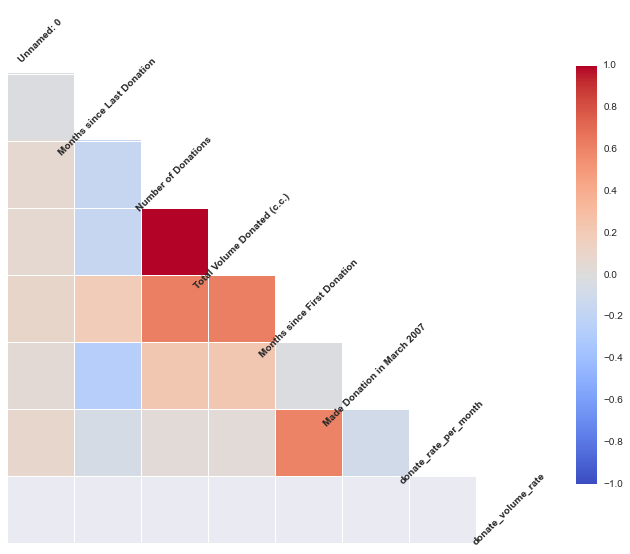

In [98]:
plt.figure(figsize=(12, 10))
_ = sns.corrplot(train, annot=False)

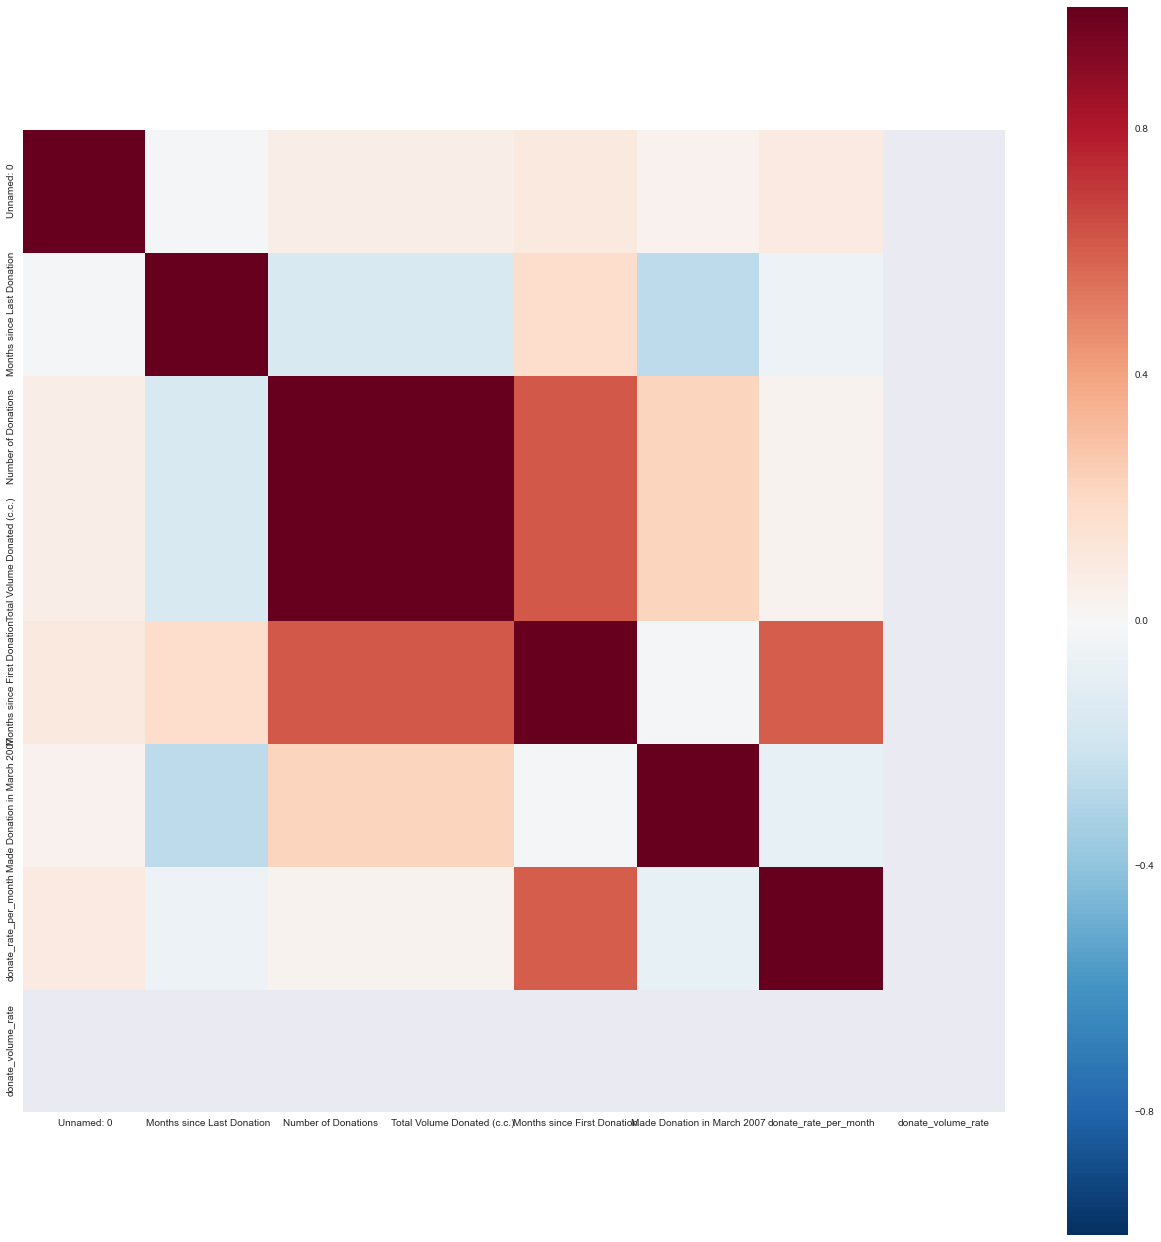

In [99]:
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 0:].corr()
plt.figure(figsize=(22, 22))
sns.heatmap(corr, vmax=1, square=True)

### Summary

- Data doesn't have NAN value.
- Data has noise data, but not too much. Consider to remove noise if need to improve model.
- Predict data has imbalanced values (150 positive value versus 400 negative value), need to consider when use xgboost.
- All features don't have normal distribute data, should try to processing data before make model(normalize, scale or apply min max).
- Dataset is small (~600 records), so can make our model underfitting. Should apply feature engineering to create new feature, example: donate_rate_per_month.
- "Total Volume Donated" has strong relation with "Number of Donated", so need to remove out of feature to avoid overfitting.